<a href="https://colab.research.google.com/github/Greta-gerasimov/NN/blob/NN5_RNN/NN_hw5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku
import numpy as np
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf
import keras
tfds.disable_progress_bar()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [ ]:
#parametrs
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'I just bought the DVD and i must say, (after seeing Brazil and Fear an loathing in Las Vegas) Terry does it again. As well of being a fan of the Monty Python movies, Terry Gilliam\'s genius follows through in this sci fi thriller, whom Bruce Willis plays a wonderful role as James Cole, and as well (perhaps my favorite character) Brad Pitt who played the insanity of Jefferey Goines. A must have for sci fi fans, or movie fan of any type really, because it includes suspense, drama, action, etc. <br /><br />any way the plot, In the future, 1% of the world\'s population survives a disease intended to wipe out the human race, which is unleashed in the past by "the army of twelve monkeys". James Cole( Bruce Willis) is sent back to 1996 (which is when the virus was unleashed) to find out about the disease, so scientists in his time can find a cure. Before i go further, James Cole lives in an underground society, and the animals rule the world on the surface due to the disease that w

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10,  41,   1, ...,   0,   0,   0],
       [ 16, 144,  37, ...,   0,   0,   0],
       [452,  56,   1, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'I just bought the DVD and i must say, (after seeing Brazil and Fear an loathing in Las Vegas) Terry does it again. As well of being a fan of the Monty Python movies, Terry Gilliam\'s genius follows through in this sci fi thriller, whom Bruce Willis plays a wonderful role as James Cole, and as well (perhaps my favorite character) Brad Pitt who played the insanity of Jefferey Goines. A must have for sci fi fans, or movie fan of any type really, because it includes suspense, drama, action, etc. <br /><br />any way the plot, In the future, 1% of the world\'s population survives a disease intended to wipe out the human race, which is unleashed in the past by "the army of twelve monkeys". James Cole( Bruce Willis) is sent back to 1996 (which is when the virus was unleashed) to find out about the disease, so scientists in his time can find a cure. Before i go further, James Cole lives in an underground society, and the animals rule the world on the surface due to the disease that

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=15,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/15
391/391 [==============================] - 62s 119ms/step - loss: 0.6331 - accuracy: 0.5760 - val_loss: 0.4837 - val_accuracy: 0.7448
Epoch 2/15
391/391 [==============================] - 28s 72ms/step - loss: 0.3969 - accuracy: 0.8185 - val_loss: 0.3678 - val_accuracy: 0.8458
Epoch 3/15
391/391 [==============================] - 27s 68ms/step - loss: 0.3445 - accuracy: 0.8526 - val_loss: 0.3445 - val_accuracy: 0.8464
Epoch 4/15
391/391 [==============================] - 28s 70ms/step - loss: 0.3233 - accuracy: 0.8622 - val_loss: 0.3392 - val_accuracy: 0.8391
Epoch 5/15
391/391 [==============================] - 28s 71ms/step - loss: 0.3135 - accuracy: 0.8655 - val_loss: 0.3264 - val_accuracy: 0.8568
Epoch 6/15
391/391 [==============================] - 27s 68ms/step - loss: 0.3068 - accuracy: 0.8690 - val_loss: 0.3262 - val_accuracy: 0.8562
Epoch 7/15
391/391 [==============================] - 27s 69ms/step - loss: 0.3037 - accuracy: 0.8704 - val_loss: 0.3228 - val_accuracy

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 13s 32ms/step - loss: 0.3222 - accuracy: 0.8645
Test Loss: 0.3221653401851654
Test Accuracy: 0.8644800186157227


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[0.6827906]


In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 63ms/step
[0.6827907]


(0.0, 0.650310231745243)

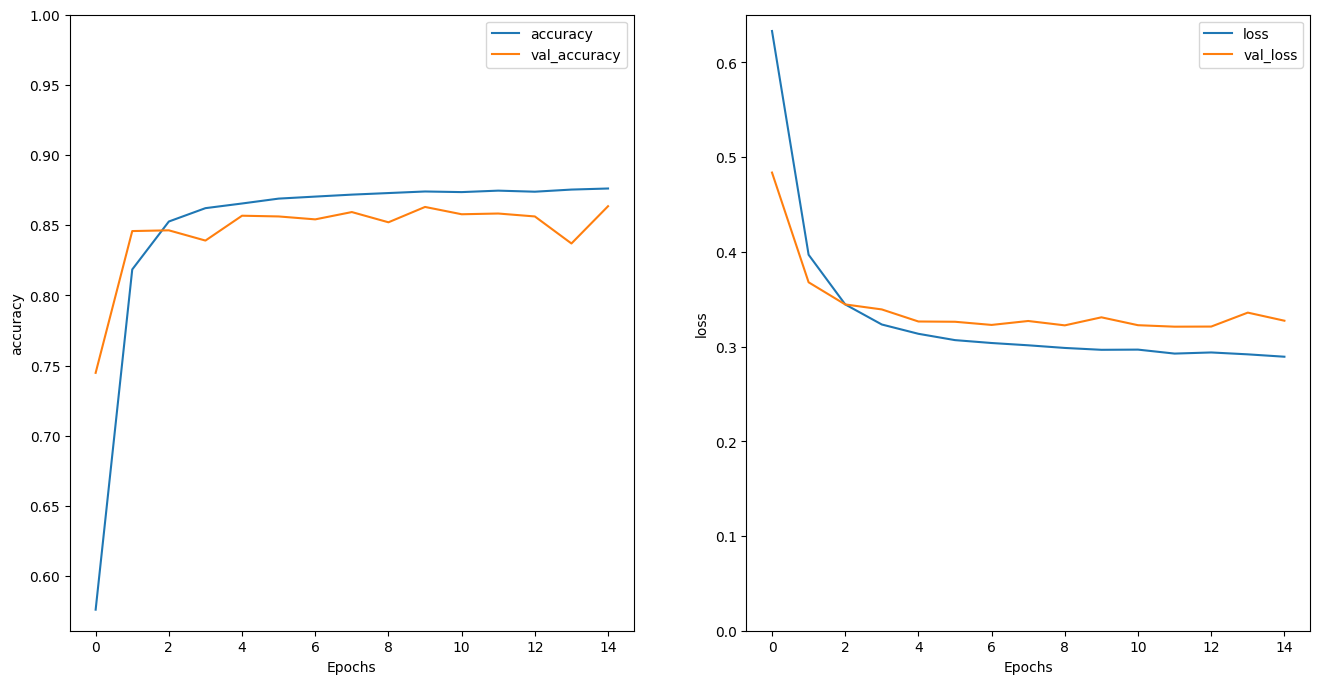

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 0s 24ms/step
[[0.6827906]]


конкатинация еще одного слоя LSTM

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=15,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/15
391/391 [==============================] - 86s 173ms/step - loss: 0.6309 - accuracy: 0.5766 - val_loss: 0.4438 - val_accuracy: 0.7641
Epoch 2/15
391/391 [==============================] - 50s 127ms/step - loss: 0.3718 - accuracy: 0.8384 - val_loss: 0.3463 - val_accuracy: 0.8484
Epoch 3/15
391/391 [==============================] - 52s 131ms/step - loss: 0.3330 - accuracy: 0.8564 - val_loss: 0.3316 - val_accuracy: 0.8443
Epoch 4/15
391/391 [==============================] - 50s 126ms/step - loss: 0.3178 - accuracy: 0.8641 - val_loss: 0.3468 - val_accuracy: 0.8562
Epoch 5/15
391/391 [==============================] - 50s 127ms/step - loss: 0.3097 - accuracy: 0.8682 - val_loss: 0.3228 - val_accuracy: 0.8562
Epoch 6/15
391/391 [==============================] - 49s 126ms/step - loss: 0.3057 - accuracy: 0.8678 - val_loss: 0.3197 - val_accuracy: 0.8531
Epoch 7/15
391/391 [==============================] - 49s 126ms/step - loss: 0.3033 - accuracy: 0.8702 - val_loss: 0.3179 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 20s 52ms/step - loss: 0.3252 - accuracy: 0.8490
Test Loss: 0.325176864862442
Test Accuracy: 0.8489599823951721


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 5s 5s/step
[[-2.3706002]]


In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 112ms/step
[-2.3706002]


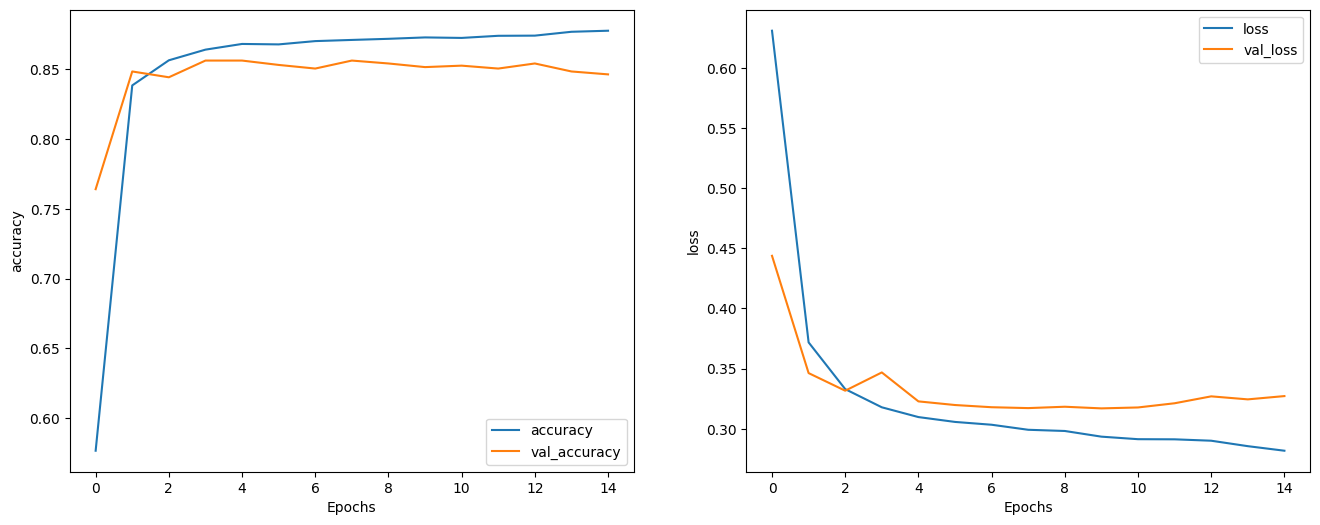

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')